In [1]:
import sys 
assert sys.version_info >= (3, 7)

import tensorflow as tf 
import sklearn 
from packaging import version

assert version.parse(tf.__version__) >= version.parse("2.8.0")
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt 

plt.rc("font", size = 14)
plt.rc("axes", labelsize = 12, titlesize = 16)
plt.rc("legend", fontsize = 14)
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)

import tensorflow_datasets as tfds 

2025-05-27 17:45:27.120029: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 17:45:27.194139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748349927.238983   44111 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748349927.252619   44111 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748349927.314047   44111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


I0000 00:00:1748349960.020679   44111 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


dataset_size : 3670


2025-05-27 17:46:00.899346: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-27 17:46:01.074633: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-27 17:46:01.092710: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


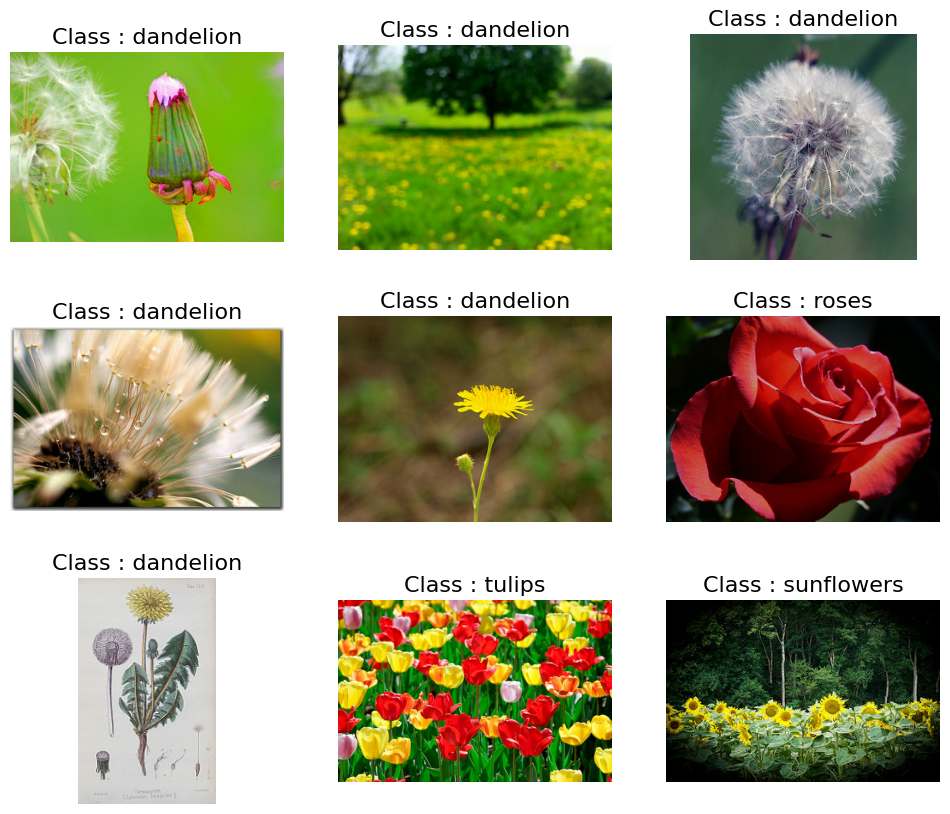

In [3]:
import tensorflow_datasets as tfds 
datasets, info = tfds.load("tf_flowers", as_supervised = True, with_info = True)
datasetSize = info.splits["train"].num_examples
print(f"dataset_size : {datasetSize}")
classNames = info.features["label"].names 
numClasses = info.features["label"].num_classes

testSetRaw, validSetRaw, trainSetRaw = tfds.load(
    "tf_flowers", 
    split = ["train[:10%]", "train[10%:25%]", "train[25%:]"], 
    as_supervised=True
)

plt.figure(figsize = (12, 10))
index = 0 
for image, label in validSetRaw.take(9):
    index += 1 
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class : {classNames[label]}")
    plt.axis("off")
plt.show()

2025-05-27 17:46:20.912874: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-27 17:46:21.082418: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


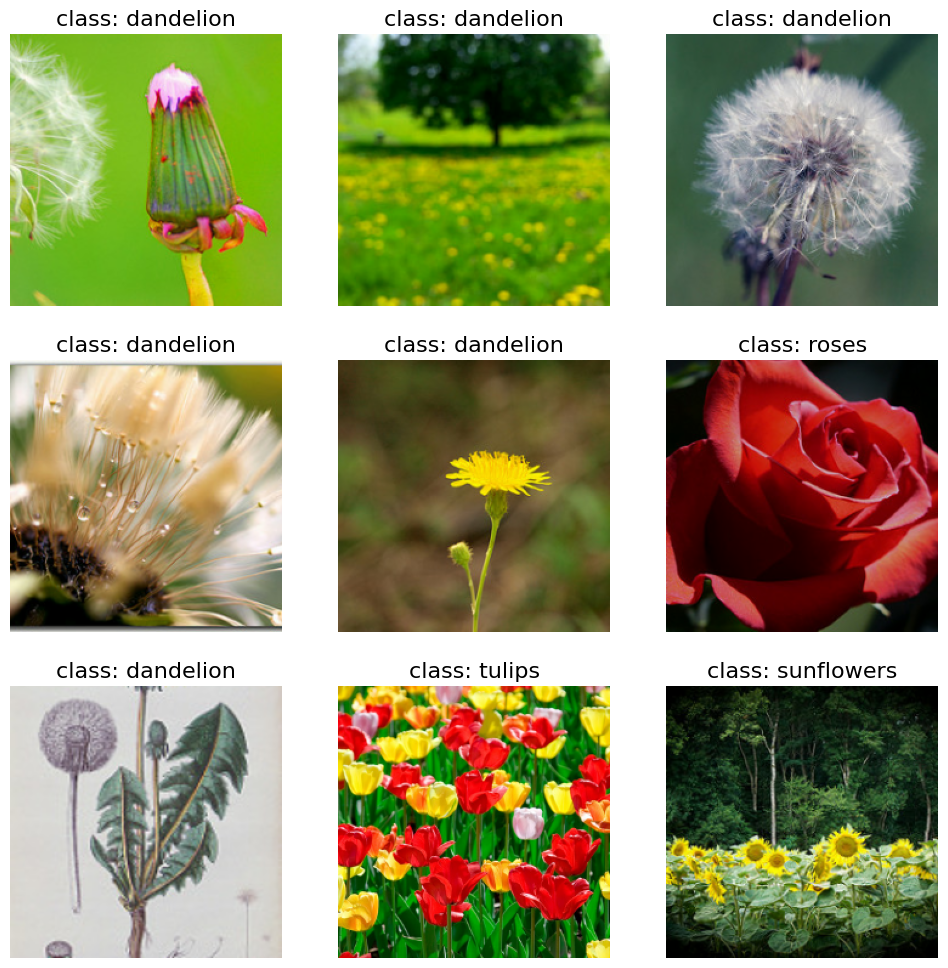

In [4]:
tf.keras.backend.clear_session()
batchSize = 16 
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height = 224, width = 224, crop_to_aspect_ratio = True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

trainSet = trainSetRaw.map(lambda X, y : (preprocess(X), y))
trainSet = trainSet.shuffle(1000, seed= 42).batch(batchSize).prefetch(1)

validSet = validSetRaw.map(lambda X, y: (preprocess(X), y)).batch(batchSize)
testSet = trainSetRaw.map(lambda X, y: (preprocess(X), y)).batch(batchSize)

plt.figure(figsize=(12 , 12))
for xBatch, yBatch in validSet.take(1):
    for i in range(9):
        plt.subplot(3, 3, i +1)
        plt.imshow((xBatch[i] + 1)/ 2)
        """
        X_batch[index] + 1: This shifts the range of values. If a pixel value was -1,
         adding 1 makes it 0. If a pixel value was 1, 
         adding 1 makes it 2. So, the range [-1, 1] is shifted to [0, 2].
        """
        plt.title(f"class: {classNames[yBatch[i]]}")
        plt.axis("off")

plt.show()


augmenting the images, like rotating a bit, flipping them and tweaking contrast

In [6]:
dataAugmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal", seed = 42),
    tf.keras.layers.RandomRotation(factor = 0.1, seed = 42),
    tf.keras.layers.RandomContrast(factor = 0.2, seed = 42)
])


displaying the same images now that are augmented

2025-05-27 17:46:39.226513: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


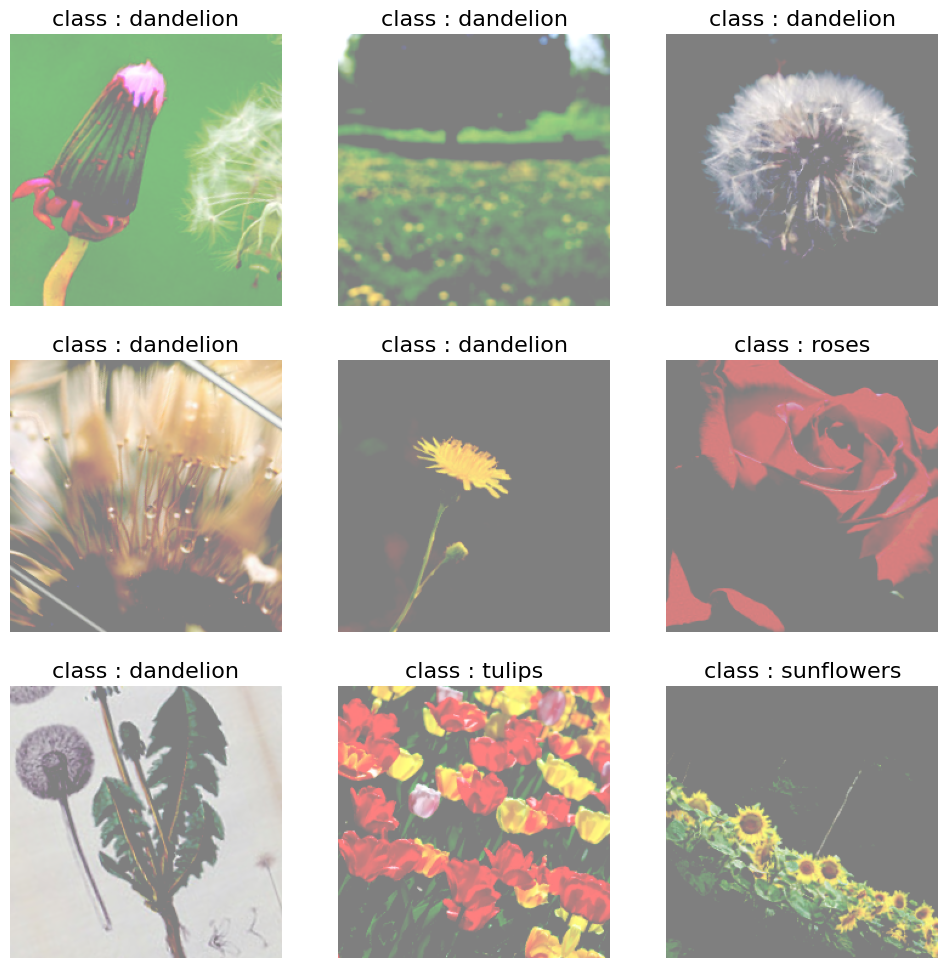

In [7]:
import numpy as np
plt.figure(figsize = (12 , 12))
for xBatch, yBatch in validSet.take(1):
    xBatchAugmented = dataAugmentation(xBatch, training = True)
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.clip((xBatchAugmented[i] + 1)/2, 0, 1))
        plt.title(f"class : {classNames[yBatch[i]]}")
        plt.axis("off")
plt.show()

loading the Xception model with the top removed 

In [8]:
tf.random.set_seed(42)
base_model = tf.keras.applications.Xception(weights = "imagenet", include_top= False)


adding a globalaveragelayer 

In [9]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(numClasses, activation = "softmax")(avg)

model = tf.keras.Model(inputs = base_model.inputs, outputs = output)


In [10]:
for layer in base_model.layers:
    layer.trainable = False 


In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(trainSet,validation_data = validSet, epochs = 3)


Epoch 1/3


I0000 00:00:1748350030.573568   44352 service.cc:152] XLA service 0x7fbd70002d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748350030.573662   44352 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-05-27 17:47:10.719796: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748350032.400878   44352 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-27 17:47:14.152915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3896', 76 bytes spill stores, 76 bytes spill loads

2025-05-27 17:47:14.912819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

163/172 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7105 - loss: 1.6267

2025-05-27 17:47:47.067467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 132 bytes spill stores, 132 bytes spill loads

2025-05-27 17:47:47.209928: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 4 bytes spill stores, 4 bytes spill loads

2025-05-27 17:47:47.740288: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1030', 1416 bytes spill stores, 1416 bytes spill loads

2025-05-27 17:47:52.347656: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performanc

172/172 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.7155 - loss: 1.6124 - val_accuracy: 0.7858 - val_loss: 1.8188
Epoch 2/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.8817 - loss: 0.8717 - val_accuracy: 0.8584 - val_loss: 1.2429
Epoch 3/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.9287 - loss: 0.3971 - val_accuracy: 0.8621 - val_loss: 1.0451


In [12]:

for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()


  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

unfreezing the base_model layers 56 and above 

In [13]:
for layer in base_model.layers[56:]:
    layer.trainable = True 

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
history = model.fit(trainSet, validation_data = validSet, epochs = 10)


Epoch 1/10


2025-05-27 17:49:01.107681: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-27 17:49:01.382388: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


172/172 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.8238 - loss: 0.5960 - val_accuracy: 0.8947 - val_loss: 0.3351
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9627 - loss: 0.1118 - val_accuracy: 0.9147 - val_loss: 0.2844
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.9846 - loss: 0.0556 - val_accuracy: 0.9274 - val_loss: 0.2900
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.9871 - loss: 0.0338 - val_accuracy: 0.9165 - val_loss: 0.3141
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.9903 - loss: 0.0331 - val_accuracy: 0.9183 - val_loss: 0.2733
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.9962 - loss: 0.0131 - val_accuracy: 0.9147 - val_loss: 0.3444
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9902 - loss: 0.0314 - val_accuracy: 0.9220 - val_loss: 0.2970
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.9976 - loss: 0.0082 - val

In [15]:
model.save("test_model.keras")

In [7]:
from tensorflow import keras
model = keras.models.load_model("test_model.keras")

In [16]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

classOutput = tf.keras.layers.Dense(numClasses, activation="softmax")(avg)

locationOutput = tf.keras.layers.Dense(4)(avg)

model = tf.keras.Model(inputs = base_model.input, outputs = [classOutput, locationOutput])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9)
model.compile(loss = ["sparse_categorical_crossentropy", "mse"],
              optimizer = optimizer,
              loss_weights = [0.8, 0.2],
              metrics = ["accuracy", "mse"])


In [17]:
fakeBatch = trainSet.take(1)
counter = 1
for x, y in fakeBatch:
    print(counter)
    print(x.shape)
    counter += 1

1
(16, 224, 224, 3)


2025-05-27 17:53:54.209423: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
len(x)

16

In [19]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

# fakeTrainSet = trainSet.take(5).repeat(2).map(add_random_bounding_boxes)
fakeTrainSet = trainSet.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fakeTrainSet, epochs = 2)

Epoch 1/2


2025-05-27 17:56:49.467888: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 76 bytes spill stores, 76 bytes spill loads

2025-05-27 17:56:50.345407: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 3816 bytes spill stores, 3796 bytes spill loads

2025-05-27 17:56:56.673619: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-27 17:56:56.979408: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - dense_1_accuracy: 0.2586 - dense_1_loss: 1.5646 - dense_2_loss: 0.2774 - dense_2_mse: 0.2774 - loss: 1.3072
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - dense_1_accuracy: 0.4899 - dense_1_loss: 1.2557 - dense_2_loss: 0.1744 - dense_2_mse: 0.1744 - loss: 1.0394
